In [5]:
from utils import *
from models import *
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math


### Load the clip trained weights

In [2]:
model_c = CLIP(
    image_embedding_dim=2048,
    text_embedding_dim=1024,
    projection_dim=512
).to('mps')

state_dict = torch.load("clip.pt")
model_c.load_state_dict(state_dict)

<All keys matched successfully>

### Load the saved image embeddings of our dataset

In [3]:
image_embeddings = torch.load("image_embeddings.pt")
image_embeddings.shape

torch.Size([2872, 512])

### Define the inference function and read our description file

In [6]:
@torch.inference_mode()
def inference(model_clip,query: str, df: pd.DataFrame, n_top_images: int=5, device='mps'):

  query_tokenized = tokenizer([query], padding=True, truncation=True, max_length=200)

  tokens, attention_mask = query_tokenized['input_ids'], query_tokenized['attention_mask']
  tokens, attention_mask = torch.tensor(tokens).to(device), torch.tensor(attention_mask).to(device)

  query_embedding = model_clip.text_projection(model_clip.text_encoder(tokens, attention_mask)) # 1, projection_dim

  logits = image_embeddings @ query_embedding.T # No of images, 1
  top_n_indices = torch.topk(logits.squeeze(), n_top_images).indices.tolist()
  top_image_paths = df.iloc[top_n_indices]['image_path'].to_list()
  top_image_captions = df.iloc[top_n_indices]['caption'].to_list()

  fig, axes = plt.subplots(nrows=3, ncols=math.ceil(n_top_images//3), figsize=(20, 8))
  for ax, img_path, caption in zip(axes.flatten(), top_image_paths, top_image_captions):
      img = Image.open(img_path)
      img = img.resize((300, 300))
      img = mpimg.pil_to_array(img)
      ax.imshow(img)
      # ax.set_title(caption)
      ax.axis('off')

  plt.tight_layout()
  plt.show()


# Load the dictionary from the JSON file
with open("upper_garment_description.json", 'r') as file:
    upper_garment_description = json.load(file)

df = pd.DataFrame(list(upper_garment_description.items()), columns=["image_path", "caption"])
df

,image_path,caption
0,upper_garment_images/upper_image_100.jpg,"The image showcases a cozy, oversized cardigan..."
1,upper_garment_images/upper_image_1000.jpg,"The image features a light blue, long-sleeved ..."
2,upper_garment_images/upper_image_10001.jpg,The garment in the image is a woman's mini dre...
3,upper_garment_images/upper_image_10002.jpg,The garment in the image is a women's halter-n...
4,upper_garment_images/upper_image_10003.jpg,"The image depicts a person wearing a casual, u..."
...,...,...
2867,upper_garment_images/upper_image_3087.jpg,The image depicts a young person wearing a cla...
2868,upper_garment_images/upper_image_3088.jpg,The clothing item visible is a classic denim j...
2869,upper_garment_images/upper_image_3089.jpg,"This image showcases a form-fitting, knee-leng..."
2870,upper_garment_images/upper_image_3090.jpg,The image showcases a sleeveless women's midi ...


In [7]:
def vlm_text(image_path):

    # print("Processing:", image_path)
    detection = detect_clothing(image_path, model_yolo, labels, upper, lower)
    
    for j, detect in enumerate(detection):
        if detect['category'] == 'upper':
            try:
                return process_image(detect['cropped_image'])
            except:
                return 'Exhaustion error'
        else:
            return 'None detected'
        
vlm_text('datasets/fashion_dataset/train/images/image_30.jpg')


image 1/1 /Users/saptarshimallikthakur/Desktop/google_lens/Google-Lens-Fashion-Alternative-main/datasets/fashion_dataset/train/images/image_30.jpg: 640x448 1 dress, 1 neckline, 56.9ms
Speed: 2.9ms preprocess, 56.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 448)


'Exhaustion error'

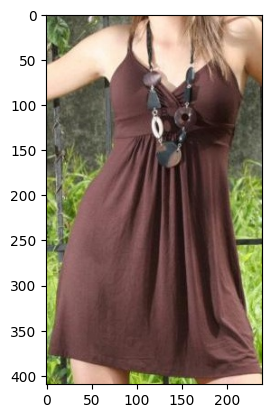

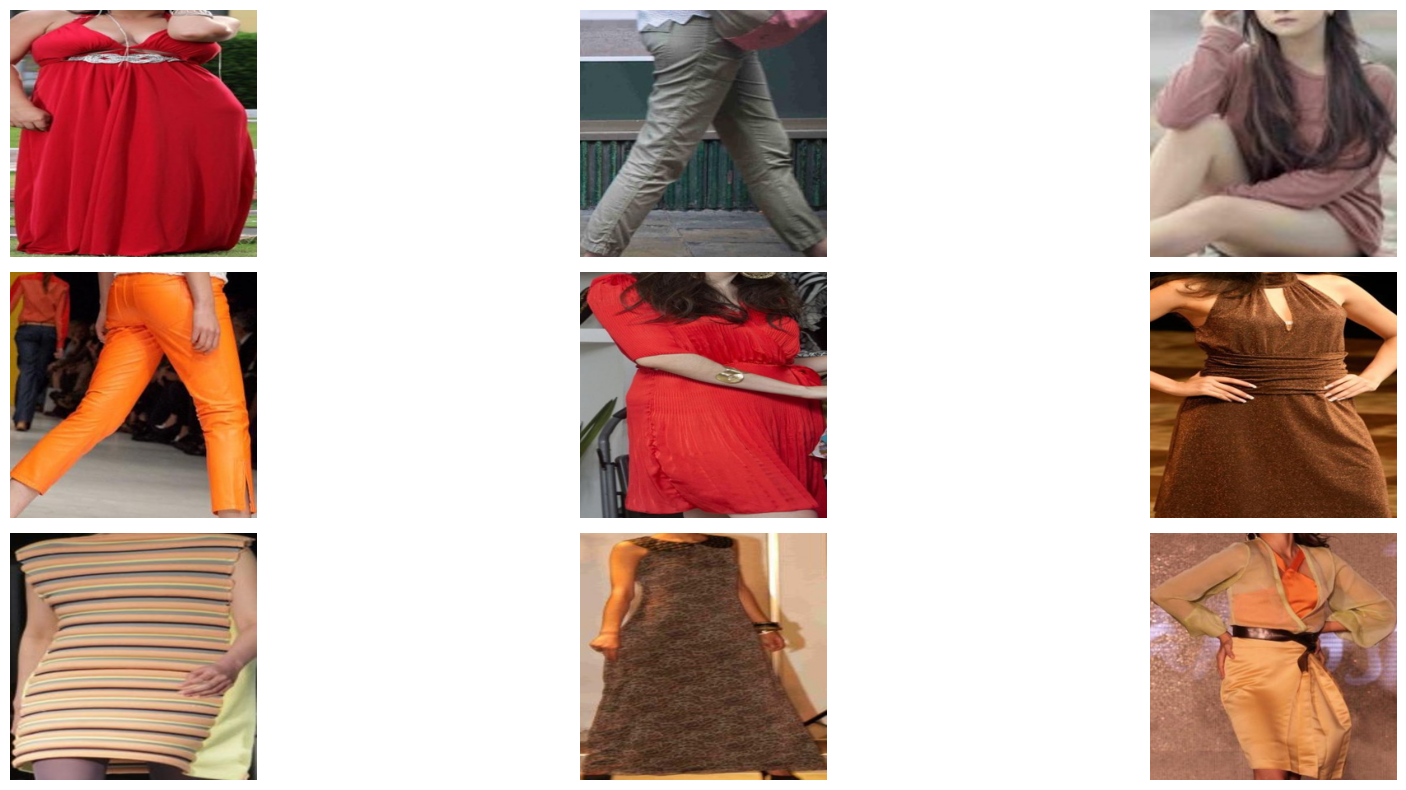

In [8]:
j = 620

imgss = cv2.imread(df['image_path'][j])
imgss = cv2.cvtColor(imgss,cv2.COLOR_BGR2RGB)
plt.imshow(imgss)
plt.show()

inference(model_c,query=df['caption'][j], df=df, n_top_images=9)